# MultiClassNetwork 

In [1]:
import numpy as np

class MultiClassNetwork:
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.sigmoid(z1)               # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def softmax(self, z):
        # 소프트맥스 함수
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
 
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.softmax(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

# Practice - Fashion MNIST 

In [4]:
import tensorflow as tf
(X_train_all, y_train_all), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() # load data

(60000, 28, 28) (60000,)


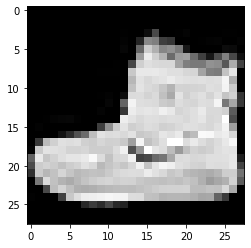

In [8]:
print(X_train_all.shape, y_train_all.shape)
import matplotlib.pyplot as plt
plt.imshow(X_train_all[0], cmap='gray')
plt.show()

In [10]:
print(y_train_all[:10]) # index: 0~9
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트',
               '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']
print(class_names[y_train_all[0]])
print(np.bincount(y_train_all)) # target 분포 확인

[9 0 0 3 0 2 7 2 5 5]
앵클부츠
[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, stratify = y_train_all, test_size=0.2, random_state=42)
# 레이블이 잘 나뉘었는지 확인
print(np.bincount(y_train))
print(np.bincount(y_val)) 
# 이미지 정규화
X_train = X_train/255.
X_val = X_val/255. 
# 2차원 배열 -> 1차원 변환
X_train = X_train.reshape(-1, 784) # 784=28*28
X_val = X_val.reshape(-1, 784)
print(X_train.shape, X_val.shape)

[4800 4800 4800 4800 4800 4800 4800 4800 4800 4800]
[1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]
(48000, 784) (12000, 784)


In [14]:
# 원-핫 인코딩
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
# 원-핫 인코딩 확인
print(y_train_encoded.shape, y_val_encoded.shape)
print(y_train[0], y_train_encoded[0])

(48000, 10) (12000, 10)
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [16]:
# 다중분류신경망을 40번 epoch 동안 훈련
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(X_train, y_train_encoded, x_val=X_val, y_val=y_val_encoded, epochs=40)

........................................

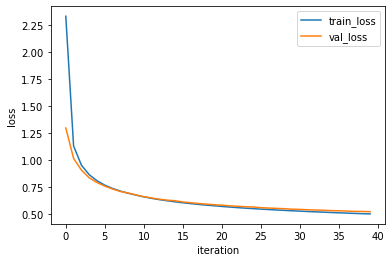

In [17]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [18]:
fc.score(X_val, y_val_encoded)
# 무작위로 10가지 중 하나의 의류를 선택할 경우의 확률인 10% 보다는 높지만 오차가 크다.
# 제대로 된 모델을 만들기 위해선 전문 딥러닝 패키지를 사용해야 한다.

0.8150833333333334

# Practice - Keras를 이용한 모델
* Keras: Sequential 클래스 + Dense 클래스
* Sequential: 인공신경망 모델을 만들기 위한 클래스. 순차적으로 층을 쌓은 신경망 모델
* Dense: 완전 연결층을 만들기 위한 클래스. 모델에 포함된 완전 연결층

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [22]:
# 모델 객체 생성
model = Sequential() 
# 은닉층 유닛(노드) 100개, 28*28 이미지를 펼쳐서 입력 
model.add(Dense(100, activation='sigmoid', input_shape=(784,))) 
# 출력층 유닛(노드) 10개
model.add(Dense(10, activation='softmax'))
# 모델 학습 설정
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) # cf. categorical: 원핫 O vs sparse: 원핫 X
# 모델 학습
history = model.fit(X_train, y_train_encoded, epochs=40,
                    validation_data=(X_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/40


48000/48000 [==============================] - 6s 130us/sample - loss: 1.3825 - accuracy: 0.6608 - val_loss: 0.9581 - val_accuracy: 0.7241
Epoch 2/40
48000/48000 [==============================] - 5s 114us/sample - loss: 0.8369 - accuracy: 0.7441 - val_loss: 0.7489 - val_accuracy: 0.7615
Epoch 3/40
48000/48000 [==============================] - 6s 117us/sample - loss: 0.7086 - accuracy: 0.7655 - val_loss: 0.6633 - val_accuracy: 0.7816
Epoch 4/40
48000/48000 [==============================] - 6s 118us/sample - loss: 0.6449 - accuracy: 0.7819 - val_loss: 0.6143 - val_accuracy: 0.7897
Epoch 5/40
48000/48000 [==============================] - 5s 114us/sample - loss: 0.6040 - accuracy: 0.7939 - val_loss: 0.5780 - val_accuracy: 0.8011
Epoch 6/40
48000/48000 [==============================] - 6s 115us/sample - loss: 0.5741 - accuracy: 0.8037 - val_loss: 0.5509 - val_accuracy: 0.8112
Epoch 7/40
48000/48000 [==============================] - 5s 114us/sample - loss: 0.5509 - accuracy: 0.8121 - v

In [23]:
# 측정 지표 확인
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


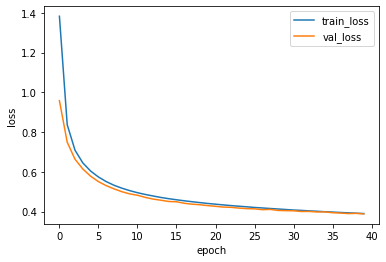

In [24]:
# loss 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

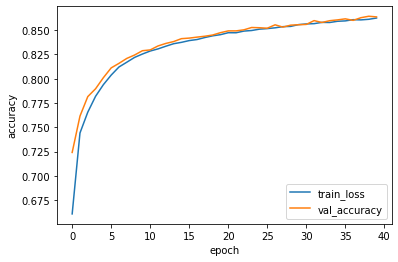

In [25]:
# accuracy 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_accuracy'])
plt.show()

In [26]:
# 모델 평가 -> MultiClassNetwork보다 더 효과 좋고 간단한 방법으로 구현 
loss, accuracy = model.evaluate(X_val, y_val_encoded, verbose=0)
print(loss, accuracy)

0.3884383631547292 0.86366665
